In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, r2_score
import os
from dotenv import load_dotenv
import yfinance as yf
import pandas as pd
import pandas_ta as ta
from scikeras.wrappers import KerasRegressor
# Load environment variables from the .env file
load_dotenv('../.env');

# Data Viz. 
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.ndimage import gaussian_filter
from calendar import monthrange
from calendar import month_name

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
import requests
import csv
from itertools import permutations
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf

import statsmodels.graphics.tsaplots as tsaplot
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing, SimpleExpSmoothing

import warnings
warnings.filterwarnings('ignore')


In [3]:
def load_and_prepare(ticker, period="max"):
    df = pd.DataFrame()
    df = df.ta.ticker(ticker, period=period)
    df.ta.adjusted = "adj_close"
    df.reset_index(inplace=True)
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    df['rsi']  = ta.rsi(df.close, length=15)
    df['emaf'] = ta.ema(df.close, length=20) #fast moving avg
    df['emam'] = ta.ema(df.close, length=100) #medium moving avg
    df['emas'] = ta.ema(df.close, length=150) #slow moving avg
    #df['macd'] = ta.macd(df.close, fast=12, slow=26, signal=9) #moving average convergance and divergance
    
    df['vma']  = ta.sma(df.volume, length=20) # Volume Moving Average
    df['vrc']  = ta.roc(df.volume, length=5) # Volume Rate of change
    df.drop(['date','dividends', 'stock_splits'], axis=1, inplace=True)
    #df['close'] = np.log(df['close'])
    #df['open'] = np.log(df['open'])
    df['target']            = ((df.close - df.open)/df.open)*100
    df['target']            = df.target.shift(-1)
    #df['target_class']      = [2 if df.target[i]>1 and 0 if df.target[i]< (-1) else 1 for i in range(len(df))]
    df['target_class'] = np.select([(df['target'] > 1), (df['target'] < -1), ((df['target'] >= -1) & (df['target'] <= 1))], [2, 0, 1], default=np.nan)
    df['target_next_close'] = df.close.shift(-1)
    df.dropna(inplace=True)
    return df

In [4]:
df = load_and_prepare("AAPL")

In [5]:
df

,open,high,low,close,volume,rsi,emaf,emam,emas,vma,vrc,target,target_class,target_next_close
149,0.089387,0.089818,0.089387,0.089387,19824000,45.489539,0.090299,0.097269,0.097453,31013920.0,-64.068210,-0.515427,1.0,0.083342
150,0.083773,0.083773,0.083342,0.083342,23654400,39.340073,0.089636,0.096994,0.097266,30821280.0,-48.285994,-0.518105,1.0,0.082910
151,0.083342,0.083342,0.082910,0.082910,31942400,38.937228,0.088996,0.096715,0.097076,31876320.0,61.494904,-1.093806,0.0,0.078159
152,0.079024,0.079024,0.078159,0.078159,22668800,34.743595,0.087964,0.096347,0.096826,32258240.0,106.952965,0.000000,1.0,0.080319
153,0.080319,0.080751,0.080319,0.080319,34451200,37.996465,0.087236,0.096030,0.096607,32829440.0,126.176471,0.000000,1.0,0.082910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10852,193.899994,194.399994,191.729996,192.529999,42628800,51.966107,193.234092,184.517782,180.981296,53138740.0,-8.290647,-0.806837,1.0,185.639999
10853,187.149994,188.440002,183.889999,185.639999,82488700,37.001110,192.510845,184.540004,181.043000,54979210.0,122.204952,0.016284,1.0,184.250000
10854,184.220001,185.880005,183.429993,184.250000,58414500,34.832884,191.724098,184.534261,181.085477,55730460.0,101.991404,-0.131754,1.0,181.910004
10855,182.149994,183.089996,180.880005,181.910004,71983600,31.503164,190.789422,184.482296,181.096398,55998220.0,49.692333,-0.445086,1.0,181.179993


In [6]:
df.isna().sum()

open                 0
high                 0
low                  0
close                0
volume               0
rsi                  0
emaf                 0
emam                 0
emas                 0
vma                  0
vrc                  0
target               0
target_class         0
target_next_close    0
dtype: int64

In [7]:
df['target_class'].value_counts()

target_class
1.0    4923
0.0    2924
2.0    2861
Name: count, dtype: int64

In [8]:
df.dtypes

open                 float64
high                 float64
low                  float64
close                float64
volume                 int64
rsi                  float64
emaf                 float64
emam                 float64
emas                 float64
vma                  float64
vrc                  float64
target               float64
target_class         float64
target_next_close    float64
dtype: object

In [9]:
df['target_class'] = df['target_class'].astype(int)

In [10]:
df.dtypes

open                 float64
high                 float64
low                  float64
close                float64
volume                 int64
rsi                  float64
emaf                 float64
emam                 float64
emas                 float64
vma                  float64
vrc                  float64
target               float64
target_class           int64
target_next_close    float64
dtype: object

<Axes: >

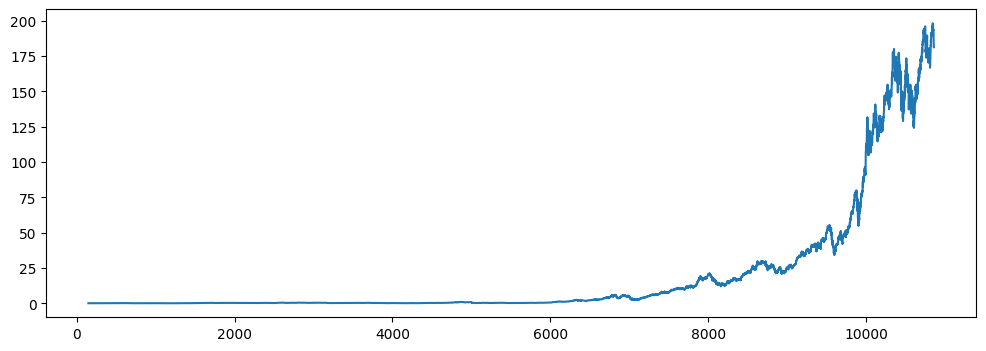

In [11]:
#plt.plot(df['close'])
df['close'].plot(figsize=(12,4))

In [12]:
# take index as feature and log transformed as close

In [13]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'rsi', 'emaf', 'emam', 'emas',
       'vma', 'vrc', 'target', 'target_class', 'target_next_close'],
      dtype='object')

In [14]:
df.isna().sum()

open                 0
high                 0
low                  0
close                0
volume               0
rsi                  0
emaf                 0
emam                 0
emas                 0
vma                  0
vrc                  0
target               0
target_class         0
target_next_close    0
dtype: int64

In [15]:
from sklearn.model_selection import train_test_split

# Assuming X is your feature set and y is your target variable
X = df.drop(['open','high', 'low', 'close', 'volume','target','target_class', 'target_next_close'], axis=1)# Adjust columns accordingly
y = df[['target_class']]  # Adjust the target variable accordingly

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
#def add_features(X):   
    
    #X['rsi']  = ta.rsi(X.close, length=15)
    #X['emaf'] = ta.ema(X.close, length=20) #fast moving avg
    #X['emam'] = ta.ema(X.close, length=100) #medium moving avg
    #X['emas'] = ta.ema(X.close, length=150) #slow moving avg
    ##df['macd'] = ta.macd(df.close, fast=12, slow=26, signal=9) #moving average convergance and divergance
    
    #X['vma']  = ta.sma(X.volume, length=20) # Volume Moving Average
    #X['vrc']  = ta.roc(X.volume, length=5) # Volume Rate of change
    #return X

In [17]:
#X_train.isna().sum()

In [18]:
#add_features(X_test)

In [19]:
#X_test.isna().sum()

In [20]:

# Create a preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler(feature_range=(0,1)))
])

# Apply the preprocessing pipeline to numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', preprocessing_pipeline, X_train.columns)
    ])

In [21]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

In [22]:
# Fit and transform the training data
train_features_preprocessed = preprocessor.fit_transform(X_train)

# Transform the test data using the learned parameters from the training data
test_features_preprocessed = preprocessor.transform(X_test)

In [23]:
train_features_preprocessed.shape

(8566, 6)

In [24]:
test_features_preprocessed.shape

(2142, 6)

In [25]:
# train_features_preprocessed and test_features_preprocessed are preprocessed data

# Reshape training data
X_train_lstm = train_features_preprocessed.reshape((train_features_preprocessed.shape[0], 1, train_features_preprocessed.shape[1]))

# Reshape testing data
X_test_lstm = test_features_preprocessed.reshape((test_features_preprocessed.shape[0], 1, test_features_preprocessed.shape[1]))

# Check the new shapes
print("Shape of X_train_lstm:", X_train_lstm.shape)
print("Shape of X_test_lstm:", X_test_lstm.shape)


Shape of X_train_lstm: (8566, 1, 6)
Shape of X_test_lstm: (2142, 1, 6)


In [26]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))  # 3 units for your three categories
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

2024-01-08 18:04:08.893752: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-01-08 18:04:08.893790: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-08 18:04:08.893810: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-08 18:04:08.893849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-08 18:04:08.893868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [27]:
# Build LSTM model
##model.add(LSTM(units=50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
#model.add(Dense(units=1, activation='sigmoid'))  # Binary classification output layer

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Make predictions

Epoch 1/10


2024-01-08 18:04:10.965663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


215/215 [==============================] - 14s 43ms/step - loss: 1.0692 - accuracy: 0.4562 - val_loss: 1.0532 - val_accuracy: 0.4609
Epoch 2/10
215/215 [==============================] - 4s 17ms/step - loss: 1.0577 - accuracy: 0.4599 - val_loss: 1.0489 - val_accuracy: 0.4609
Epoch 3/10
215/215 [==============================] - 4s 17ms/step - loss: 1.0546 - accuracy: 0.4609 - val_loss: 1.0440 - val_accuracy: 0.4638
Epoch 4/10
215/215 [==============================] - 4s 17ms/step - loss: 1.0511 - accuracy: 0.4603 - val_loss: 1.0404 - val_accuracy: 0.4714
Epoch 5/10
215/215 [==============================] - 4s 17ms/step - loss: 1.0483 - accuracy: 0.4618 - val_loss: 1.0386 - val_accuracy: 0.4737
Epoch 6/10
215/215 [==============================] - 4s 18ms/step - loss: 1.0460 - accuracy: 0.4606 - val_loss: 1.0348 - val_accuracy: 0.4726
Epoch 7/10
215/215 [==============================] - 4s 17ms/step - loss: 1.0439 - accuracy: 0.4615 - val_loss: 1.0327 - val_accuracy: 0.4737
Epoch 8/1

In [28]:
# Assuming X_test_lstm and y_test are your test data
evaluation = model.evaluate(X_test_lstm, y_test)
print(f"Test Loss: {evaluation[0]}, Test Accuracy: {evaluation[1]}")


67/67 [==============================] - 2s 26ms/step - loss: 1.0455 - accuracy: 0.4636
Test Loss: 1.0455418825149536, Test Accuracy: 0.46358543634414673


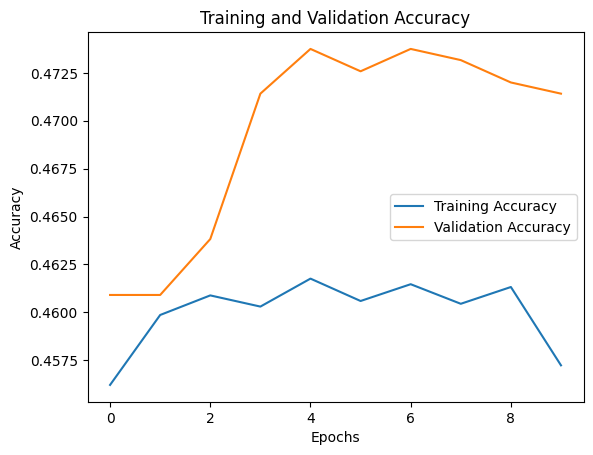

In [29]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


67/67 [==============================] - 2s 14ms/step


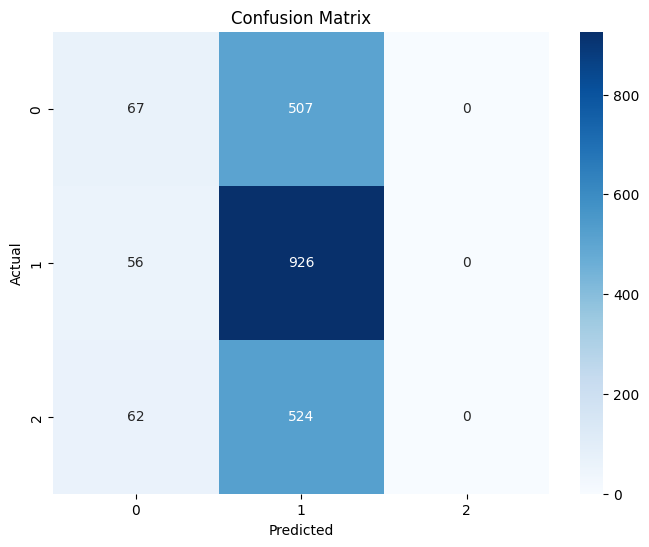

In [30]:

# Get model predictions on the test set
predictions = model.predict(X_test_lstm)
predicted_classes = np.argmax(predictions, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [31]:
from sklearn.metrics import classification_report

# Print classification report
print(classification_report(y_test, predicted_classes))


              precision    recall  f1-score   support

           0       0.36      0.12      0.18       574
           1       0.47      0.94      0.63       982
           2       0.00      0.00      0.00       586

    accuracy                           0.46      2142
   macro avg       0.28      0.35      0.27      2142
weighted avg       0.31      0.46      0.34      2142



In [33]:
y_test

,target_class
3031,1
4082,1
453,1
3474,1
2775,1
...,...
9556,0
10391,2
1252,2
9912,0
